# Pushed-Pulled Front Transitions in Tumor Growth (Simulations) 
### Senior Project Code Notebook by Hana Herbawi 


This code is based on the `biolgca` Python Package. Installation instructions and documentation can be found [here](https://github.com/sisyga/biolgca).

### Loading the Packages

In [16]:
from lgca import get_lgca
import numpy.random as npr
import numpy as np
from bisect import bisect_left
from random import random
import matplotlib.pyplot as plt

### Defining the Functions 
We have 2 functions, `random_walk` and `birthdeathae`. The `birthdeathae` function is a custom-made function used as an interaction for the LGCA model to describe birth and death with Nagumo/Allee reaction.

In [17]:
def random_walk(lgca):
    """
    Shuffle config in the last axis, modeling a random walk.
    :return:
    """
    # disarrange(lgca.nodes, axis=-1)
    relevant = (lgca.cell_density[lgca.nonborder] > 0) & \
               (lgca.cell_density[lgca.nonborder] < lgca.K)
    coords = [a[relevant] for a in lgca.nonborder]
    for coord in zip(*coords):
        npr.shuffle(lgca.nodes[coord])

def birthdeathae(lgca):
    """
    - Birth Death with Allee Growth
    Variables:
    - n: Node Density (No. of Cells)
    - rho: Mean-Field Density
    - rb: Birth Rate
    - rd: Death Rate
    - rb_tilde: Mean-Field Birth Rate
    - rd_tilde: Mean-Field Death Rate
    - a: Allee Parameter
    - a_tilde: Mean-Field Allee Parameter
    - I: Indicator Function 
    - lgca.K: Carrying Capacity
    :return:
    """
    n = lgca.cell_density[..., None]     # Arbitrary values, between 0,1,2
    # n=np.ones((52,52,1))               # Manually force all n values to be 1 (if needed)
    # n[n > 1] = 1                       # Manually set n=2 values as n=1      (if needed)
    
    rb = lgca.interaction_params['r_b']
    rd = lgca.interaction_params['r_d']
    rb_tilde = rb/ lgca.K
    rd_tilde = rd/ lgca.K 
    rd_tilde = rb_tilde        
    
    rho = n/lgca.K
    a = 3                                # Set manually. In case of values n = 1 (all or some) the threshold is around -2.4
    a_tilde = a/ lgca.K
    I = np.where((n + a) > 0, 1, 0)     
    
    birth = npr.random(lgca.nodes.shape) < (rb_tilde * (rho)**2 + rb_tilde * (a/lgca.K) * rho * I)*(1 - rho) # Full description 
    death = npr.random(lgca.nodes.shape) < (rd_tilde * (np.abs(a)/lgca.K) * rho * (1-I))*(1 - rho)           # of the model

    ds = (1 - lgca.nodes) * birth - (lgca.nodes) * death            # Tests if cell is full or not. If full, only death takes place

    np.add(lgca.nodes, ds, out=lgca.nodes, casting='unsafe')    
    lgca.update_dynamic_fields()
    random_walk(lgca) 

### Simulating for Homogenous Initial Conditions

 For this simulation, we set the initial conditions to homogenous, starting at the value of `density`, on a lattice of dimension `dims`. We simulate for 100 timesteps. Setting the allee parameter to be above around -2.5, we get logistic growth, and setting it around -3 or less, we get an exponential decay.

100%|██████████| 100/100 [00:00<00:00, 121.10it/s]


<IPython.core.display.Javascript object>


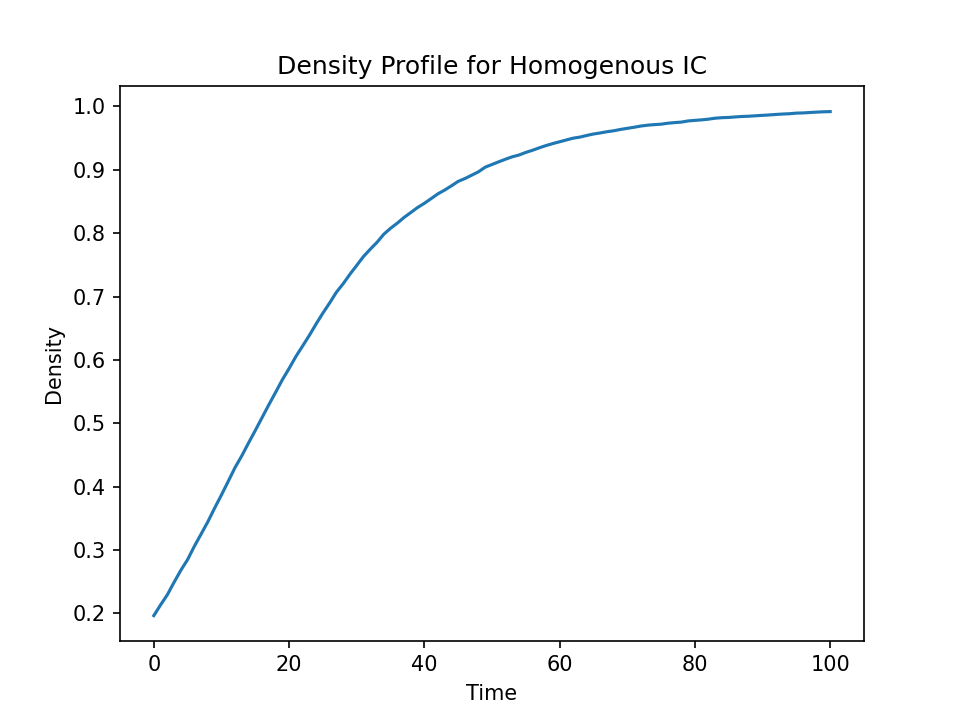

In [18]:
%matplotlib notebook

lgca = get_lgca(interaction='birthdeath',geometry='square', restchannels=1, density=0.2, # n=1
                r_b = 1, r_d = 0.5, bc='periodic', dims=(50,50))
lgca.interaction = birthdeathae

lgca.timeevo(100,recordN=True)
plt.xlabel('Time')
plt.ylabel('Density')
plt.title('Density Profile for Homogenous IC')
plt.plot(lgca.n_t/(lgca.lx*lgca.ly*lgca.K))

### Simulating for Nonhomogenous Initial Conditions
We now opt for a nonhomogenous initial condition where set the initial condition to be a thin strip of cells simulating growth in a tube which is a 400 by 20 lattice. We simulate it for 200 timesteps and plot the density profile. 

100%|██████████| 200/200 [00:01<00:00, 121.07it/s]


<IPython.core.display.Javascript object>


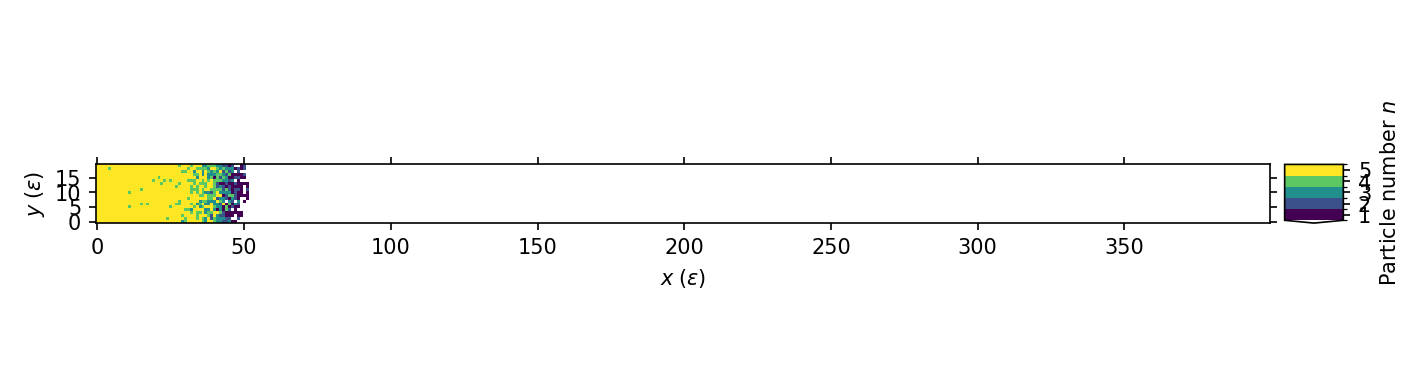

(<Figure size 800x60 with 2 Axes>,
 <matplotlib.cm.ScalarMappable at 0x1aa70524110>)

In [19]:
%matplotlib notebook
nodes = np.zeros((400, 20, 5))
nodes[0:2, 0:21, :] = 1
lgca = get_lgca(interaction='birthdeath',geometry='square', restchannels=1, nodes=nodes, # n=1
                r_b = 1, r_d = 0.5, bc='refl', dims=(400,20))
lgca.interaction = birthdeathae
lgca.timeevo(timesteps=200, record=True)
lgca.plot_density()

### Projecting the Simulation onto the X-Axis (1D Simulation)

To project the model on the x-axis and get 1D simulations, we average over the y-axis. We set the initial conditions to be a strip of cells just like the previous simulation. We simulate it for 1000 timesteps.

100%|██████████| 1000/1000 [00:08<00:00, 118.82it/s]


<IPython.core.display.Javascript object>


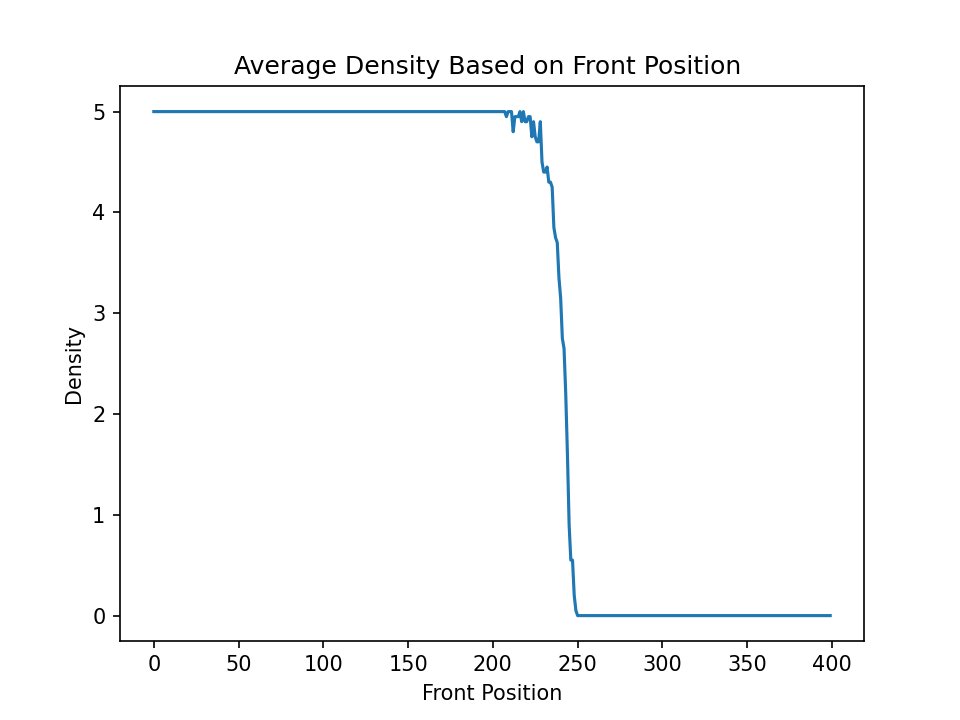

In [20]:
%matplotlib notebook
nodes = np.zeros((400, 20, 5))
nodes[0:2, 0:21, :] = 1
lgca = get_lgca(interaction='birthdeath',geometry='square', restchannels=1, nodes=nodes, # n=1
                r_b = 1, r_d = 0.5, bc='refl', dims=(400,20))
lgca.interaction = birthdeathae

lgca.timeevo(timesteps=1000, record=True, recorddens=True)
average_dens = np.mean(lgca.dens_t, axis=-1) #lgca.dens_t: (time, x, y)
plt.xlabel('Front Position')
plt.ylabel('Density')
plt.title('Average Density Based on Front Position ')
plt.plot(average_dens[-1]) #(-1 is the last index)


The x-axis corresponds to the front position and we notice that in the middle, the density is equal to 5 (full node) which coincides with our initial condition. 

### Repeating the Simulations and Taking the Average

We will now repeat the simulations 10 times, and take their average in order to reduce the noise. 

100%|██████████| 1000/1000 [00:08<00:00, 113.30it/s]


<IPython.core.display.Javascript object>


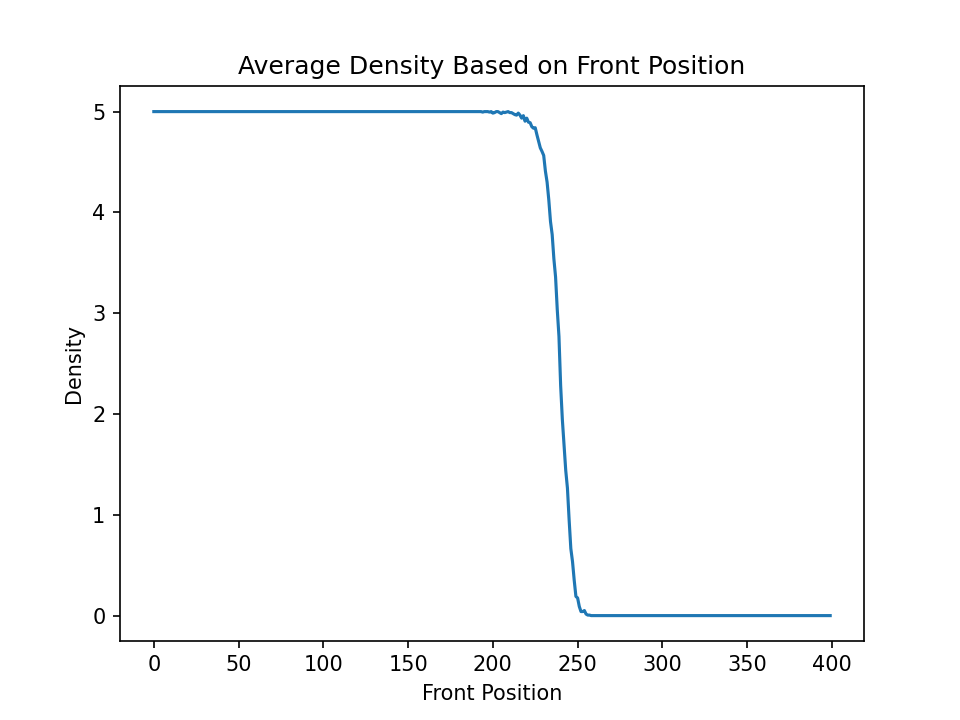

In [21]:
num_simulations = 10
average_densities = []

for _ in range(num_simulations):
    nodes = np.zeros((400, 20, 5))
    nodes[0:2, 0:21, :] = 1
    lgca = get_lgca(interaction='birthdeath',geometry='square', restchannels=1, nodes=nodes, # n=1
                r_b = 1, r_d = 0.5, bc='refl', dims=(400,20))
    lgca.interaction = birthdeathae
    lgca.timeevo(timesteps=1000, record=True, recorddens=True)
    average_dens = np.mean(lgca.dens_t, axis=-1)
    average_densities.append(average_dens)

average_densities = np.stack(average_densities, axis=-1)
average_density_avg = np.mean(average_densities, axis=-1)

plt.xlabel('Front Position')
plt.ylabel('Density')
plt.title('Average Density Based on Front Position')
plt.plot(average_density_avg[-1])
plt.show()


### Calculating the Front Speed

We calculate the front speed by plotting the time evolution of the front position. 

<IPython.core.display.Javascript object>


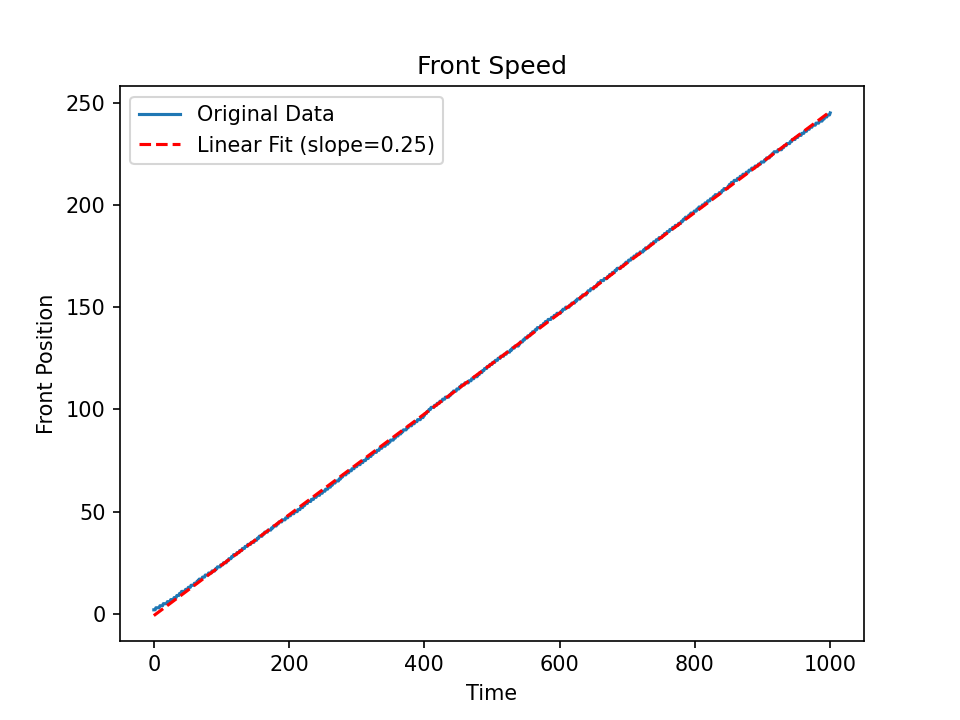

In [22]:
%matplotlib notebook
# Defining the front position as the mean position of the foremost cells
front_position = np.abs(average_density_avg - 1).argmin(axis=-1).astype(float)

# Plotting the linear fit
time = np.arange(len(front_position))
coefficients = np.polyfit(time, front_position, 1)
linear_fit = np.poly1d(coefficients)

# Calculating the slope of the linear fit
slope = coefficients[0]

plt.xlabel('Time')
plt.ylabel('Front Position')
plt.title('Front Speed')
plt.plot(time, front_position, label='Original Data')
plt.plot(time, linear_fit(time), color='red', linestyle='--', label=f'Linear Fit (slope={slope:.2f})')
plt.legend()
plt.show()

The slope of the front position vs. time is the front speed, which evolves linearly indicating that the tumor grows (invades healthy tissue) at a constant speed. 